# <center>Projet Final du module MDI721 : Kit Big Data</center>

<img src="https://cdn.radiofrance.fr/s3/cruiser-production/2019/12/5c2e55be-71b6-4c2c-8376-c2bcfedf6754/1200x680_vendee_globe.jpg" width="400" align="center"/>

Le projet porte sur les données du Vendée Globe 2020-2021. 

Nous avons à dispositions les classements de la course, mis à jour toutes les 3 heures, contenant les caractéristiques de performance de chacun des concurrents (vitesse, cap...). Nous disposons aussi des caractéristiques de chaque bateau grâce au glossaire disponible directement sur le site de l'évènement. Les différentes étapes du traitement des données seront : 

- La récupération des fichiers Excel avec les classements
- La récupération des caractéristiques des voiliers pour chaque skipper
- Le rapprochement des précédents jeux de données ainsi que le nettoyage du dataset obtenu
- Évaluation de l'influence du foil sur les classements des skippers
- Influence et contribution de chaque paramètre du bateau sur le classement des skippers
- Modélisation de l'influence de la vitesse utile (VMG) sur le classement 
- Visualisation des trajectoires des skippers sur geopandas 
- 2ème méthode de visualisation : Basemap, application aux trajectoires des 3 meilleurs skippers 
- Tracé de l'évolution des distances restantes jusqu'à l'arrivée
- Construction d'un modèle de Machine Learning pour la prédiction du cap suivi (analyse de série temporelle)
- Conclusion sur le modèle et idées d'ouvertures

Les données les plus récentes au moment de l'envoi de ce projet sont: le 29/11/2020 à 14:00

In [3]:
# To avoid 'warning' messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import of useful libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import glob
from bs4 import BeautifulSoup
import re
import random

#Modules for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#Module for classification with XGboost
from xgboost import XGBClassifier

# Modules for map visualization
from mpl_toolkits.basemap import Basemap
import geopandas

In [2]:
# Tensorflow for deep learning algorithms, the tensorflow version used is 2.3.1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

## Récupération des fichiers Excel avec les classements 

Dans cette partie, les fichiers sont récupérés directement à partir du site du classement du Vendée Globe puis enregistrés sous forme de fichiers xlsx dans le répertoire courant. 

https://www.vendeeglobe.org/fr/classement

In [10]:
r = requests.get('https://www.vendeeglobe.org/fr/classement')
soup = BeautifulSoup(r.content, 'html.parser')
all_ranking_dates = soup.find('select',{'class':"form__input m--select onsubmit-rank"})\
                        .find_all('option')[1:]
all_ending_urls = list(map(lambda x:(list(x.attrs.values())[0],re.sub('^(-)','',x.text).strip()), all_ranking_dates))


header = ['Rank', 'Sail', 'Skipper','Hour FR', 'Latitude','Longitude','Since 30 minutes - Heading',
         'Since 30 minutes - Speed','Since 30 minutes - VMG','Since 30 minutes - Distance',
         'Since the last report - Heading', 'Since the last report - Speed', 'Since the last report - VMG',
         'Since the last report - Distance', 'Since 24 hours - Heading', 'Since 24 hours - Speed',
          'Since 24 hours - VMG', 'Since 24 hours - Distance','DTF','DTL']


# Conversion of the excel file content into a dataframe
def dataframe_conversion(file):

    df = pd.read_excel(file, usecols = 'B:U', names=header)
    df = df.iloc[4:37]   
    df = df.reset_index(drop=True)
    
    # We get rid of the sponsor following the skipper name, which is not useful here 
    df['Skipper'] = df['Skipper'].replace('\n.*','',regex = True)   
    df = df.replace('\n','',regex = True)
    
    # We add a column with the date information of the ranking
    url = re.fullmatch('vendeeglobe_(.*)\.xlsx',file).groups()[0]
    date = all_ending_urls[[a[0] for a in all_ending_urls].index(url)][1]
    df.insert(0,'Date',date)
    
    return df


# Concatenation of all the files in a single dataframe df_ranking
df_ranking = pd.DataFrame(columns = ['Date'] + header)

for file in glob.glob('*.xlsx')[1:]:
    df = dataframe_conversion(file)
    df_ranking = df_ranking.append(df)

    
new_files = []
for url,date in all_ending_urls:
    file_name = 'vendeeglobe_' + str(url) + '.xlsx'
    
    # If the file already exists in the directory, we don't download it again
    if file_name in glob.glob('*.xlsx'):
        continue 
        
    # Otherwise we use the requests module to get its content and then save it in a xlsx file
    else:
        new_files.append(file_name)
        dls = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_' + str(url) + '.xlsx'
        resp = requests.get(dls)
        resp.encoding = 'utf-8'
        with open(file_name, 'wb') as output:
            output.write(resp.content)   
        df = dataframe_conversion(file_name)   
        df_ranking = df_ranking.append(df)

df_ranking = df_ranking.reset_index(drop=True)

## Récupération des caractéristiques des voiliers pour chaque skipper  

Nous récupérons ensuite les caractéristiques des voiliers grâce au glossaire référençant tous les bateaux de la compétition : 

https://www.vendeeglobe.org/fr/glossaire

In [11]:
r = requests.get('https://www.vendeeglobe.org/fr/glossaire')
soup = BeautifulSoup(r.content, 'html.parser')

# List of the skippers' names
boat_skippers = soup.find('section',{'class':"boats-list"}).find_all('span',{'class':"boats-list__skipper-name"})
boat_skippers = list(map(lambda x:x.text,boat_skippers))


# List of lists of features
section_boat_features = soup.find('section',{'class':"boats-list"}).find_all('ul',{'class':"boats-list__popup-specs-list"})
section_boat_features = list(map(lambda x:x.findAll('li'),section_boat_features))


# List of dictionnaries with data of each skipper provided
all_skipper_boat_features = []
for skipper_name, boat in zip(boat_skippers, section_boat_features):
    dict_boat = {}
    skipper_name = skipper_name.title()
    dict_boat['Skipper'] = skipper_name
    boat = list(map(lambda x:x.text, boat))
    for feature in boat:
        feature = feature.split(':')
        key = feature[0].strip()
        value = feature[1].strip()
        dict_boat[key] = value
    all_skipper_boat_features.append(dict_boat)

    
# We observe some values are missing for some boats (Ex : previous name if it's the first time the boat navigates)
# The first skipper presented in the glossary has all the features provided, we use it as reference keys
# We compare this reference to the other keys to add the eventually missing ones, with the value '-'
ref_keys = list(all_skipper_boat_features[0].keys())
for boat in all_skipper_boat_features:
    missing_keys = list(set(ref_keys).difference(set(boat.keys())))
    if missing_keys:
        for k in missing_keys:
            boat[k] = '-'

            
# Conversion to a dataframe 
df_boat_features = pd.DataFrame(all_skipper_boat_features)
df_boat_features.head() 

,Skipper,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Romain Attanasio,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Alexia Barrier,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Yannick Bestaven,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Jérémie Beyou,08,-,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2


## Rapprochement des caractéristiques du voilier avec le classement, nettoyage des données

In [12]:
# Merge the datasets on the Skippers' names
df = pd.merge(df_ranking,
              df_boat_features,
              on='Skipper',
              how='left')

# Cleaning the data before analysis
# Size data
df = df.rename({'Longueur':'Longueur (m)',
                'Largeur':'Largeur (m)',
                "Tirant d'eau":"Tirant d'eau (m)",
                'Hauteur mât': 'Hauteur mât (m)'},axis='columns')
df[['Longueur (m)','Largeur (m)',"Tirant d'eau (m)",'Hauteur mât (m)']] = \
                                     df[['Longueur (m)','Largeur (m)',"Tirant d'eau (m)",'Hauteur mât (m)']]\
                                     .apply(lambda x:x.str.replace('m',''))\
                                     .apply(lambda x:x.str.replace(',','.'))\
                                     .apply(lambda x:pd.to_numeric(x))


# Surface data
df = df.rename({"Surface de voiles au près":"Surface de voiles au près (m2)",
                'Surface de voiles au portant':'Surface de voiles au portant (m2)'},axis='columns')
df[["Surface de voiles au près (m2)",'Surface de voiles au portant (m2)']] = \
                                  df[["Surface de voiles au près (m2)",'Surface de voiles au portant (m2)']]\
                                  .apply(lambda x:x.str.replace(' m2',''))\
                                  .apply(lambda x:pd.to_numeric(x))

# Using datetime to convert the dates
df['Date'] = df['Date'].apply(lambda x:pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='ignore'))

# Remove the 'FR' part
df['Hour FR'] = df['Hour FR'].str.replace('FR','')


# Weight data
df['Déplacement (poids)'] = df['Déplacement (poids)'].str.replace('t','')
df['Déplacement (poids)'] = df['Déplacement (poids)'].str.replace(',','.')
df['Déplacement (poids)'] = df['Déplacement (poids)'].str.strip()

# Speed/VMG data
df[[name for name in df.columns if re.match('^.*(VMG|Speed).*$',name)]] = \
                                   df[[name for name in df.columns if re.match('^.*(VMG|Speed).*$',name)]]\
                                   .apply(lambda x:x.str.replace(' kts',''))\
                                   .apply(lambda x:pd.to_numeric(x))
df = df.rename({name:name + ' (kts)' for name in df.columns if re.match('^.*(VMG|Speed).*$',name)},axis='columns')


# Distance data
df[[name for name in df.columns if re.match('^.*(Distance|DTF|DTL).*$',name)]] = \
                                   df[[name for name in df.columns if re.match('^.*(Distance|DTF|DTL).*$',name)]]\
                                   .apply(lambda x:x.str.replace(' nm',''))\
                                   .apply(lambda x:pd.to_numeric(x))
df = df.rename({name:name + ' (nm)' for name in df.columns if re.match('^.*(Distance|DTF|DTL).*$',name)},axis='columns')


# Remove the lines where the rank is not present (For candidates who abandoned)
df = df.loc[df['Rank'].str.isdigit()].astype({'Rank':int})

df

,Date,Rank,Sail,Skipper,Hour FR,Latitude,Longitude,Since 30 minutes - Heading,Since 30 minutes - Speed (kts),Since 30 minutes - VMG (kts),...,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
0,2020-11-08 14:00:00,1,FRA 18,Louis Burton,15:30,46°24.46'N,01°50.48'W,241°,17.7,17.5,...,09 Juin 2015,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0
1,2020-11-08 14:00:00,2,MON 10,Boris Herrmann,15:31 1min,46°24.34'N,01°49.82'W,241°,11.1,10.9,...,07 Août 2015,18.28,5.70,4.5,7.6,foils,29.0,acier,290.0,490.0
2,2020-11-08 14:00:00,3,FRA 8,Jérémie Beyou,15:30,46°24.91'N,01°49.99'W,244°,15.5,15.5,...,18 Août 2018,18.28,5.85,4.5,8,foils,29.0,acier,320.0,600.0
3,2020-11-08 14:00:00,4,FRA 59,Thomas Ruyant,15:30,46°24.71'N,01°49.68'W,244°,13.2,13.1,...,03 Septembre 2019,18.28,5.85,4.5,8,foils,29.0,acier forgé,350.0,560.0
4,2020-11-08 14:00:00,5,FRA 53,Maxime Sorel,15:30,46°24.59'N,01°49.56'W,246°,10.9,10.9,...,07 Septembre 2007,18.28,5.50,4.5,7.7,2,29.0,acier,365.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4218,2020-11-29 14:00:00,28,FRA 50,Miranda Merron,14:30,17°10.40'S,34°25.67'W,182°,12.4,8.8,...,04 Mai 2006,18.28,5.50,4.5,8.5,2,28.0,carbone,330.0,600.0
4219,2020-11-29 14:00:00,29,FIN 222,Ari Huusela,14:30,13°52.85'S,33°56.77'W,187°,11.0,8.0,...,06 Août 2007,18.28,5.80,4.5,8.5,2,28.0,acier,270.0,580.0
4220,2020-11-29 14:00:00,30,FRFRA 69,Sébastien Destremau,14:30,13°03.12'S,33°03.76'W,174°,7.5,6.6,...,15 Janvier 2005,18.28,5.60,4.5,8.5,2,29.0,acier,250.0,650.0
4221,2020-11-29 14:00:00,31,JPN 11,Kojiro Shiraishi,14:30,10°56.71'S,33°04.74'W,186°,12.9,10.4,...,05 Septembre 2019,18.28,5.85,4.5,8,foils,29.0,acier forgé,320.0,580.0


##  Influence du foil sur la vitesse des voiliers et le classement des skippers

Le foil est une aile positionnée et profilée de façon à générer, par son déplacement dans l'eau, une force de portance qui agit sur sa vitesse et sa stabilité. Il existe 2 formes principales, en "C" et en "L". Depuis quelques années, son usage sur les voiliers s'est démocratisé, jusqu'à devenir un accessoire jugé indispensable pour remporter la course du Vendée-Globe. Nous allons vérifier l'impact que peut avoir cet équipement sur la vitesse des voiliers et donc le classement des skippers dans la compétition. 

Les types de foils et leurs caractéristiques sont détaillés sur cette page :

https://www.vendeeglobe.org/fr/actualites/19755/quels-foils-pour-gagner-le-vendee-globe

Proportion of foils: 57.58%
Proportion of derives: 42.42%


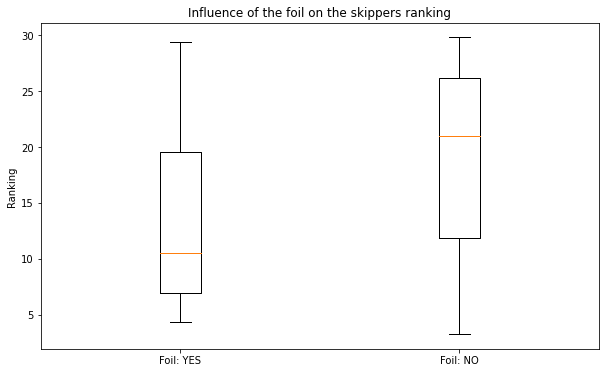

In [13]:
#First we would like to know the proportion of skippers who have a foil and plot it
nb_foils = df_boat_features.loc[df_boat_features['Nombre de dérives'].isin(['foils','foiler'])]['Nombre de dérives']\
.count()
nb_derives = df_boat_features.loc[~df_boat_features['Nombre de dérives'].isin(['foils','foiler'])]['Nombre de dérives']\
.count()

print(f'Proportion of foils: {round((nb_foils/33)*100,2)}%')
print(f'Proportion of derives: {round((nb_derives/33)*100,2)}%')

# Mean ranking of the candidates who have foils on their boat
rank_means_foils = list(df.loc[df['Nombre de dérives'].isin(['foils','foiler'])]\
                        .groupby('Skipper')\
                        .agg({'Rank':'mean'})['Rank'])

# Mean ranking of the candidates who don't
rank_means_derives = list(df.loc[~df['Nombre de dérives'].isin(['foils','foiler'])]\
                          .groupby('Skipper')\
                          .agg({'Rank':'mean'})['Rank'])


# Visualization of the means and spreading with boxplots
plt.figure(figsize=(10,6))
plt.boxplot(x=[rank_means_foils,rank_means_derives], labels=['Foil: YES','Foil: NO'])
plt.title("Influence of the foil on the skippers ranking")
plt.ylabel('Ranking')
plt.show()

On observe que le classement moyen des concurrents possédant un foil sur leur voilier est meilleur que celui des concurrents n'en possédant pas. De manière générale, les skippers possédant un foil se situent dans la partie haute du classement. 

Toutefois, avoir un foil sur son bateau ne garantit pas nécessairement une place dans le top du classement. D'autres paramètres entrent en jeu et nous allons évaluer leur importance, ce qui nous permettra de jauger également l'influence du foil.

## Influence des autres paramètres du bateau sur les performances des skippers

Nous pouvons explorer les autres caractéristiques des voiliers afin de voir quelle est la configuration typique d'un voilier du haut du classement. Pour cela, calculons les moyennes des dimensions caractéristiques des voiliers du top 5 du classement et regardons également les matériaux de voile quille ainsi que les configurations de dérives les plus récurrentes.

In [14]:
qualitative_values = ['Nombre de dérives','Voile quille']
quantitative_values = ['Longueur (m)', 'Largeur (m)', "Tirant d'eau (m)",'Déplacement (poids)','Hauteur mât (m)',
                      'Surface de voiles au près (m2)','Surface de voiles au portant (m2)']

# We only keep the data of the top 5 skippers at each date
df_only_first = df.loc[df['Rank'].isin([1,2,3,4,5])]
data = []
for v in qualitative_values:
    opti = df_only_first[v].value_counts().idxmax()
    data.append(opti)
    
for v in quantitative_values:
    # When calculating the means, we need to remove the 'NC' or '-' when the information is not provided
    opti = round(df_only_first.loc[~df_only_first[v].astype(str).isin(['NC','-']),v].apply(float).mean(),2)
    data.append(opti)

print('Among all the boat features, we get this typical configuration for the best skippers :')
pd.DataFrame([tuple(data)],columns = qualitative_values + quantitative_values, index=['Typical config'])

Among all the boat features, we get this typical configuration for the best skippers :


,Nombre de dérives,Voile quille,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids),Hauteur mât (m),Surface de voiles au près (m2),Surface de voiles au portant (m2)
Typical config,foils,acier forgé,18.28,5.73,4.5,7.95,28.5,321.33,595.79


L'acier forgé reste le matériau de référence pour la construction des voiliers, grâce à sa solidité, sa durabilité et sa grande résistance aux chocs. La plupart des voiliers de la course sont en acier forgé comme l'indique le graphe ci-dessous:

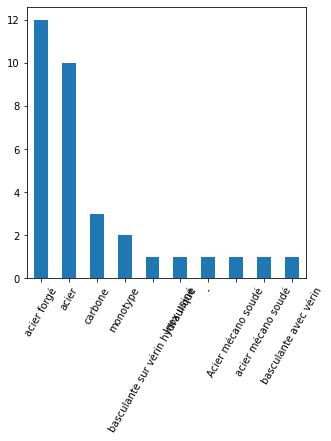

In [15]:
fig = plt.figure(figsize=(5,5))
df_boat_features['Voile quille'].value_counts().plot(kind='bar', rot=60)
plt.show()

Nous allons quantifier l'importance que peuvent avoir chacun des composants du bateau (hors matériau de voile quille) sur le classement. Pour cela nous allons construire un ensemble d'arbres de décision sur le modèle XGboost. Ce type de modèle est particulièrement adapté au type de données que nous avons (données exactes, sans bruit). Nous nous plaçons toujours sur le top 5 du classement.

Feature: Longueur (m), Score: 0.0
Feature: Largeur (m), Score: 0.15737013518810272
Feature: Tirant d'eau (m), Score: 0.0
Feature: Déplacement (poids), Score: 0.12366902083158493
Feature: Hauteur mât (m), Score: 0.16560551524162292
Feature: Surface de voiles au près (m2), Score: 0.3404620587825775
Feature: Surface de voiles au portant (m2), Score: 0.20672492682933807
Feature: Foil dummies, Score: 0.006168362218886614


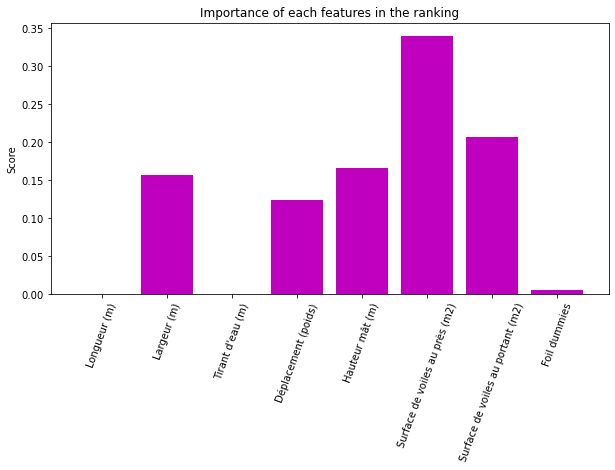

In [16]:
def is_foil(feature):
    return 1 if feature in ['foils','foiler'] else 0

quantitative_values = ['Longueur (m)', 'Largeur (m)', "Tirant d'eau (m)",'Déplacement (poids)','Hauteur mât (m)',
                      'Surface de voiles au près (m2)','Surface de voiles au portant (m2)']

df_only_first = df.loc[df['Rank'].isin([1,2,3,4,5])]
df_only_first['Foil dummies'] = df_only_first['Nombre de dérives'].apply(is_foil)
for v in quantitative_values:
    df_only_first = df_only_first.loc[~df_only_first[v].astype(str).isin(['NC','-'])]
df_only_first[quantitative_values] = df_only_first[quantitative_values].applymap(float)
df_only_first = df_only_first.dropna()

X = df_only_first[quantitative_values + ['Foil dummies']]
Y = df_only_first['Rank'].apply(int)


model = XGBClassifier()
# fit the model
model.fit(X, Y)
# get importance
importance = model.feature_importances_
# summarize feature importance
params = quantitative_values + ['Foil dummies']
for i,(v,param) in enumerate(zip(importance, quantitative_values + ['Foil dummies'])):
    print(f'Feature: {param}, Score: {v}')
    
plt.figure(figsize=(10,5))
plt.bar([x for x in range(len(params))], importance, color='m')
plt.xticks([x for x in range(len(params))], [p for p in params], rotation=70)
plt.title("Importance of each features in the ranking")
plt.ylabel("Score")
plt.show()   

Les paramètres ayant le plus d'influence sur le classement seraient donc:

- La surface de voiles au près
- La surface de voiles au portant
- La hauteur du mât

Ainsi, même si la plupart des meilleurs skippers sont équipés de foils, ce n'est pas une condition nécessaire et suffisante pour avoir les meilleures performances. Le résultat n'est d'ailleurs pas surprenant car pour atteindre les plus grandes vitesses, une bonne prise au vent est indispensable.

## Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

Nous allons examiner le lien pouvant exister entre la VMG (Velocity Made Good ou vitesse utile en français) et le rang du skipper dans le classement.

La VMG désigne le gain dans le lit du vent (mesuré en noeuds), autrement dit la projection de la vitesse surface sur l’axe du vent réel, calculée par la centrale de navigation. Autrement dit la VMG correspond au meilleur compromis cap/vitesse.

Ici, nous allons nous intéresser à la VMG moyenne correspondant à chaque rang dans le classement. En effet, cette mesure est selon moi plus objective que de prendre la VMG moyenne par rapport au classement moyen de chaque skipper, car la stratégie des skippers peut être amenée à changer en cours de route. 

The correlation between VMG and rank is : -0.9592135771789687


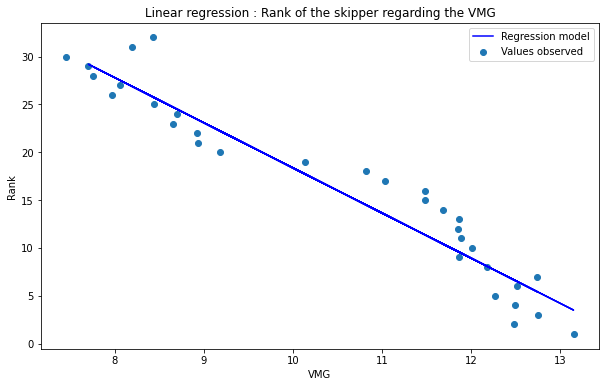

The coefficient of determination R2 is equal to: 0.8913498943748832

The root mean squared error is equal to: 7.556725713681591


In [17]:
# We should not consider the first day as the VMG is obviously equal to 0 and the ranking of the skippers has no meaning
# + we remove the data of the 33th ranking 
VMG = df.loc[(df['Since the last report - VMG (kts)'].apply(int) != 0) & (~df['Rank'].isin([33]))]\
                        .groupby('Rank')\
                        .agg({'Since the last report - VMG (kts)':'mean'})['Since the last report - VMG (kts)']

rank = df.loc[(df['Since the last report - VMG (kts)'].apply(int) != 0) & (~df['Rank'].isin([33]))].groupby('Rank')\
                                   .agg({'Rank':'mean'})['Rank']

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(VMG, rank, test_size=0.2, random_state=42)

# We compute the correlation
print(f'The correlation between VMG and rank is : {rank.corr(VMG)}')

reg = LinearRegression(n_jobs=-1)
reg.fit(X_train.to_numpy().reshape(1, -1).T, y_train.to_numpy().reshape(1, -1).T)
intercept = (reg.intercept_)[0]
reg_coef = (reg.coef_)[0]

# Plot the results
fig = plt.figure(figsize=(10,6))
plt.scatter(x=VMG.values, y=rank.values,label='Values observed')
plt.plot(X_train, intercept + reg_coef*X_train, color = 'b', label = 'Regression model')
plt.legend()
plt.title('Linear regression : Rank of the skipper regarding the VMG')
plt.xlabel('VMG')
plt.ylabel('Rank')
plt.show()

# Evaluation of the model
y_pred = reg.predict(X_test.to_numpy().reshape(1, -1).T)
print(f'The coefficient of determination R2 is equal to: {r2_score(y_test.to_numpy().reshape(1, -1).T, y_pred)}' + '\n')
print(f"The root mean squared error is equal to: {mean_squared_error(y_test.to_numpy().reshape(1, -1).T, y_pred)}")

$\textbf{Interprétation}$ : Le coefficient de corrélation est très proche de -1 (95%). D'une part cela traduit une forte corrélation négative entre la VMG moyenne et le rang. Ce qui est logique car plus la navigation est optimisée et plus le classement dans la course sera bon (rang bas). 

Le coefficient de détermination $R^{2}$ est plus proche de 1 que de 0 (0.89). Le modèle linéaire semble donc très pertinent pour modéliser le rang en fonction de la VMG. De plus l'erreur quadratique moyenne reste assez faible et permet de valider le modèle.

$\textbf{Clarification importante}$ : Concernant la VMG moyenne au 33ème rang de la course, sa valeur est très faible (proche de 0) et n'est pas représentative de la distribution des VMG moyennes selon le classement, il y a un écart très important avec la VMG moyenne de la 32ème place par exemple. Cela s'explique en partie par les performances de Fabrice Amedeo et Jérémie Beyou. En effet ces 2 skippers ont dû faire face à quelques problèmes techniques en début de course et ont dû s'arrêter (voire revenir après quelques jours pour Jérémie Beyou) puis repartir.

De plus, il y a eu un abandon de la part de Nicolas Troussel le 16 novembre dernier. Son mât s'est fracturé au large du Cap Vert et comme il l'a très justement dit : "Sans mât, impossible de naviguer". Donc plus que 32 candidats en lice et par conséquent plus de données utilisables pour la 33ème place à partir de ce moment. 

J'ai donc fait le choix de ne pas inclure les données du 33ème rang dans le modèle.

## Visualisation des skippers sur geopandas

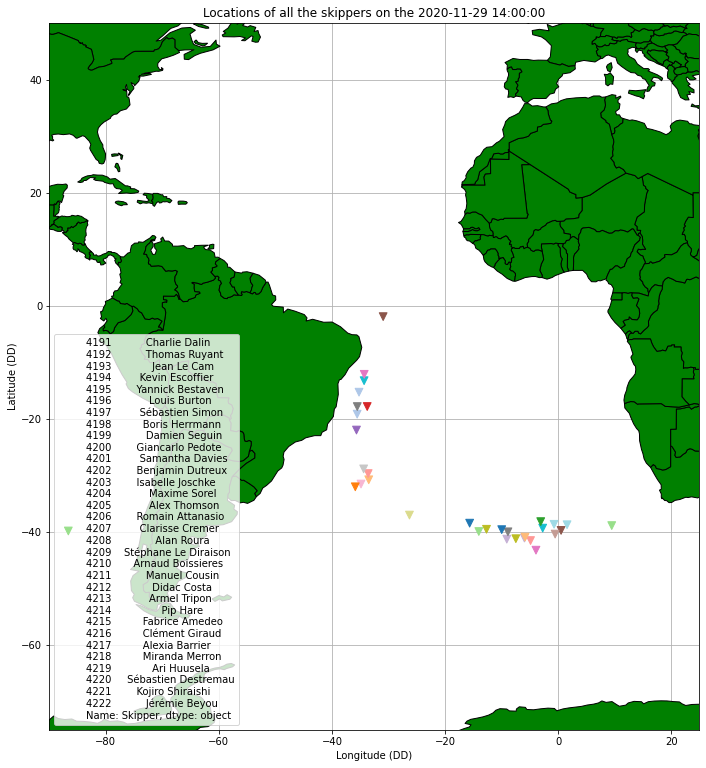

In [18]:
# Conversion from time coordinates to decimal degrees
def conversion_coord(x):
    [d,m,s,heading] = re.fullmatch("^(.*)°(.*)\.(.*)'([NSEW]{1})$",x).groups()
    coord = round(float(d) + float(m)/60 + float(s)/60,2)
    return -coord if heading in ['S','W'] else coord

# Construction of the dataframe : coordinates of the skippers on the last ranking
df_lat_long = df.loc[df['Date']==df['Date'].max(),['Skipper','Latitude','Longitude']]
df_lat_long[['Longitude','Latitude']] = df_lat_long[['Longitude','Latitude']].applymap(lambda x:conversion_coord(x))

gdf = geopandas.GeoDataFrame(df_lat_long, geometry=geopandas.points_from_xy(df_lat_long.Longitude, df_lat_long.Latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'),encoding='Windows-1252',errors = 'surrogateescape')

# Plot all the values to see the path
fig, ax = plt.subplots(figsize=(20,13))
ax.set_xlim(-90, 25)
ax.set_ylim(-75, 50)
ax.set_axisbelow(True)
plt.grid()
world.plot(ax=ax, color='green', edgecolor='black')

# creating color map for categories
categories = np.unique(gdf["Skipper"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

#matching it to the geopandas df
gdf["color"] = gdf["Skipper"].apply(lambda x: colordict[x])

gdf.plot(ax=ax, marker='v', column = 'Skipper', categorical=True, 
         markersize=60,label=gdf['Skipper'], legend=True, cmap='tab20')
plt.title(f'Locations of all the skippers on the ' + str(df['Date'].max()))
plt.xlabel('Longitude (DD)') 
plt.ylabel('Latitude (DD)')
plt.legend(loc='lower left')
plt.show()

Cela nous permet d'avoir un aperçu global, en temps réel, de la localisation de tous les voiliers du Vendée Globe.

## Méthode alternative : Visualisation sur Basemap

Visualisation des trajectoires. Nous allons construire une fonction permettant d'afficher les trajectoires d'une liste de skippers donnée. L'avantage du module Basemap est de proposer un panel de cartes plus riche.

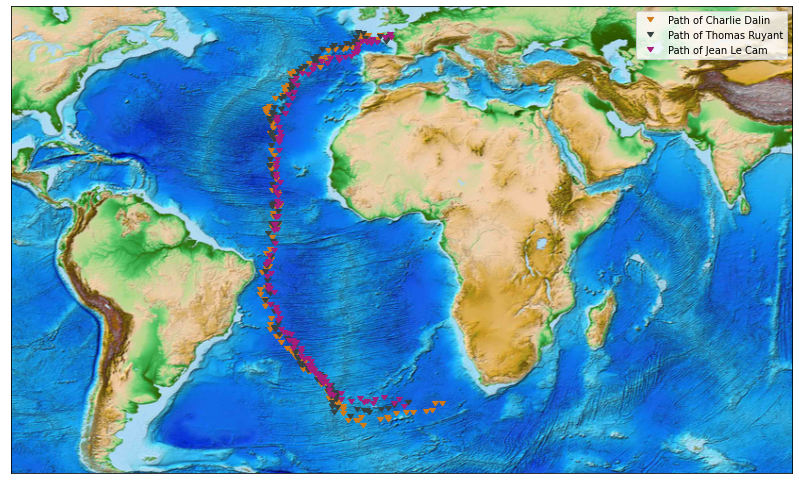

In [23]:
worst_skipper = df.groupby('Skipper').agg({'Rank':'mean'})['Rank'].idxmax()
best_skipper = df.groupby('Skipper').agg({'Rank':'mean'})['Rank'].idxmin()

import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

random.seed(51)

def plot_path_skippers(skippers):
    
    fig = plt.figure(figsize=(14, 14))
    m = Basemap(projection='cyl', resolution=None,
                llcrnrlat=-55, urcrnrlat=55,
                llcrnrlon=-92, urcrnrlon=92,)
    m.etopo(scale = 0.3)

    colors = list(np.random.rand(len(skippers),3))
    
    for i,(s,c) in enumerate(zip(skippers, colors)):
        
        lat = df.loc[df['Skipper']==s,"Latitude"].apply(conversion_coord).values
        long = df.loc[df['Skipper']==s,"Longitude"].apply(conversion_coord).values
        lons, lats = m(long, lat)
        m.scatter(lons, lats, marker = 7, color=c, label = f'Path of {s}')
    plt.legend()
    plt.show()


# Example on the top 3 skippers for the last ranking
skippers = list(df.loc[df['Rank'].isin([1,2,3]),'Skipper'].iloc[-3:].values)
plot_path_skippers(skippers)

Nous remarquons que les 3 meilleurs navigateurs ont des trajectoires relativement similaires, en particulier en début de parcours. Toutefois l'écart plus important entre certains relevés de position pour Charlie Dalin, indiquent que ce dernier a su prendre plus de vitesse que ses adversaires à certains moments de la course.

## Visualisation de la distance restante à parcourir (DTF)

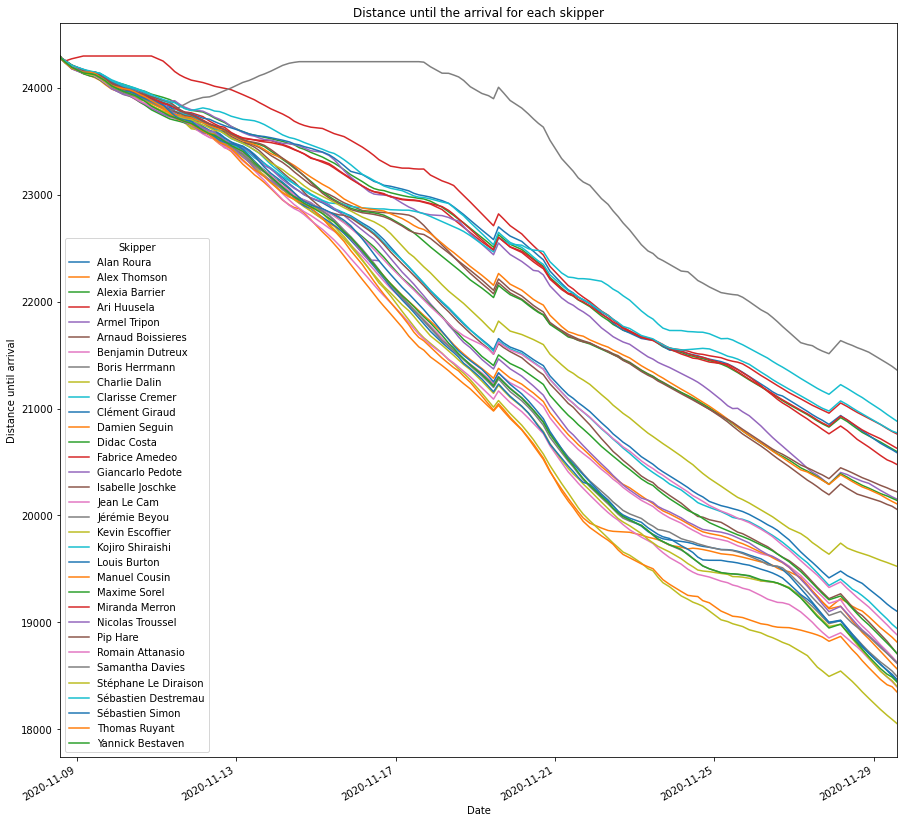

In [24]:
# Evolution of the distance left until the end 
pd.pivot_table(df, values='DTF (nm)', index='Date', columns='Skipper').plot(figsize=(15, 15))
plt.title("Distance until the arrival for each skipper")
plt.ylabel("Distance until arrival")
plt.show()

Nous pouvons constater que l'un des concurrents a eu un problème entre le 11 et le 12 novembre, sa distance à l'arrivée a augmenté jusqu'à se stabiliser à la distance qui sépare le départ de l'arrivée puis à rediminuer (courbe grise en haut). Il s'agit de Jérémie Beyou, dont le foil a été endommagé en pleine course et qui a dû revenir aux Sables d'Olonne pour effectuer les réparations nécessaires avant de repartir. 

## Prédiction du cap : Analyse de série temporelle à l'aide d'un réseau de neurones

Dans cette partie nous nous focalisons sur la donnée du cap uniquement. Nous allons mettre en place une méthode de prédiction du cap basée sur des réseaux de neurones LSTM. Compte tenu du temps de calcul nécessaire pour effectuer l'apprentissage avec tensorflow, nous nous focaliserons sur le cas d'un skipper en particulier, le modèle peut évidemment fonctionner pour n'importe quel concurrent. 
Le but de cette partie n'est pas de comparer les skippers entre eux mais de construire un modèle et de l'évaluer pour un skipper donné. 

Prédire les prochains caps suivis revient à prédire les prochaines directions empruntées par un skipper ce qui peut être utile pour évaluer sa trajectoire et/ou faire des pronostics. 

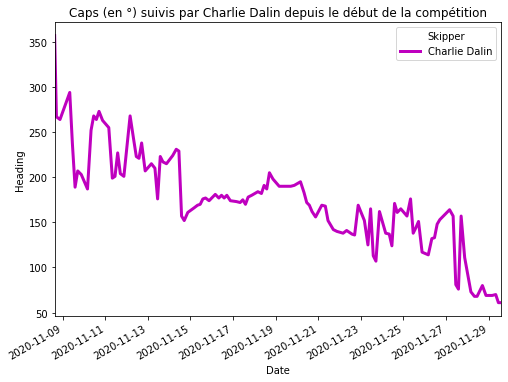

In [25]:
# Example with one skipper
skipper_name = 'Charlie Dalin'
tab = df.loc[df['Skipper']==skipper_name]
tab['Since the last report - Heading'] = tab['Since the last report - Heading'].apply(lambda x:float(x.replace('°','')))

pd.pivot_table(tab, values='Since the last report - Heading', index='Date', columns='Skipper').plot(figsize=(8,6),
                                                                                                    color='m',
                                                                                                    linewidth=3)
plt.ylabel("Heading")
plt.title(f'Caps (en °) suivis par {skipper_name} depuis le début de la compétition')
plt.show()

Nous travaillons sur des données temporelles, par conséquent nous devons utiliser les données passées pour pouvoir inférer sur les données futures. Ainsi, la base d'entraînement sera divisée en 2 parties X et Y telles que, pour un temps t donné :

- X contient la donnée mesurée au temps t
- Y contient la donnée mesurée au temps t + k, où k est un écart temporel à définir

Dans notre cas, le cap est très souvent mis à jour par le navigateur et il paraît raisonnable de prendre un pas k=1, dans le sens où la dernière mesure est celle qui est la plus corrélée à la prochaine mesure de cap. 

Préparation des données :

In [26]:
# This function takes a dataset as an argument and transforms it in two parts X and Y where Y[t+1] = X[t]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


np.random.seed(7)
dataset = tab['Since the last report - Heading'].values.astype('float32').reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create the train and test sets with respectively 80% and 20% of the data
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Transformation of the train and test parts
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshaping into [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Apprentissage à l'aide du modèle suivant : LSTM avec une couche cachée.

Les réseaux de neurones LSTM (Long Short Term Memory) sont particulièrement adaptés pour gérer les données de type séries temporelles, dans la mesure où ils ont la capacité de garder en mémoire les informations contenues dans les données sur plusieurs étapes.

In [27]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# We fit the model on 200 iterations
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
99/99 - 0s - loss: 0.1033
Epoch 2/200
99/99 - 0s - loss: 0.0332
Epoch 3/200
99/99 - 0s - loss: 0.0124
Epoch 4/200
99/99 - 0s - loss: 0.0099
Epoch 5/200
99/99 - 0s - loss: 0.0096
Epoch 6/200
99/99 - 0s - loss: 0.0093
Epoch 7/200
99/99 - 0s - loss: 0.0089
Epoch 8/200
99/99 - 0s - loss: 0.0086
Epoch 9/200
99/99 - 0s - loss: 0.0083
Epoch 10/200
99/99 - 0s - loss: 0.0080
Epoch 11/200
99/99 - 0s - loss: 0.0076
Epoch 12/200
99/99 - 0s - loss: 0.0074
Epoch 13/200
99/99 - 0s - loss: 0.0072
Epoch 14/200
99/99 - 0s - loss: 0.0069
Epoch 15/200
99/99 - 0s - loss: 0.0066
Epoch 16/200
99/99 - 0s - loss: 0.0064
Epoch 17/200
99/99 - 0s - loss: 0.0061
Epoch 18/200
99/99 - 0s - loss: 0.0061
Epoch 19/200
99/99 - 0s - loss: 0.0059
Epoch 20/200
99/99 - 0s - loss: 0.0059
Epoch 21/200
99/99 - 0s - loss: 0.0055
Epoch 22/200
99/99 - 0s - loss: 0.0055
Epoch 23/200
99/99 - 0s - loss: 0.0055
Epoch 24/200
99/99 - 0s - loss: 0.0054
Epoch 25/200
99/99 - 0s - loss: 0.0054
Epoch 26/200
99/99 - 0s - loss: 0.

Évaluation du modèle à l'aide du critère RMSE et comparaison avec les données réelles :

RMSE on training set: 20.983916539590805
RMSE on test set: 31.001059471341676


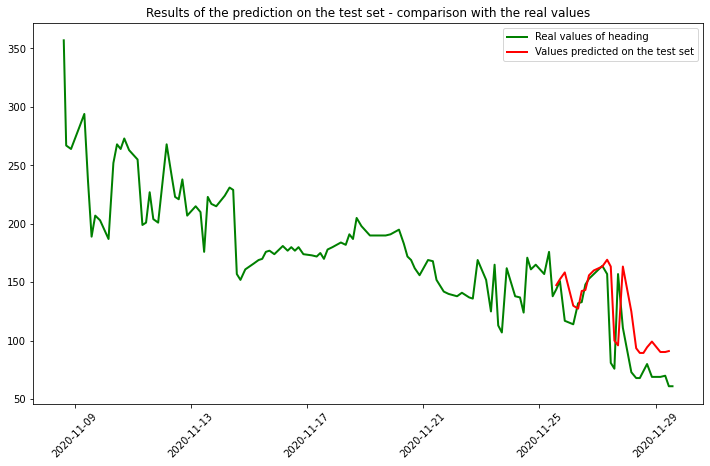

In [28]:
# Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# We use the mean squared error as a loss function
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print(f'RMSE on training set: {trainScore}')
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print(f'RMSE on test set: {testScore}')


# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(12, 7))
plt.plot(tab['Date'],scaler.inverse_transform(dataset), label = 'Real values of heading',color='green',linewidth=2)
plt.plot(tab['Date'],testPredictPlot, label = 'Values predicted on the test set', color='red',linewidth=2)
plt.legend()
plt.title("Results of the prediction on the test set - comparison with the real values")
plt.xticks(rotation = 45)
plt.show()

## Conclusion sur le modèle et idées d'ouverture

Notre modèle fait une erreur moyenne de cap de 31° sur les données de test. Ce résultat est prometteur dans la mesure où nous avons construit un réseau assez simple qui a tout de même réussi à prédire des données de cap cohérentes avec les données réelles et dans leur évolution.  

Toutefois, le Vendée Globe reste une épreuve de précision, dans laquelle une petite erreur sur le paramétrage de navigation peut avoir de grandes conséquences sur la position dans la course, il faut donc s'armer des meilleurs outils pour pouvoir optimiser sa trajectoire et faire la différence. 

Ainsi, avec plus de temps, une prochaine étape pourrait être la construction d'un modèle plus élaboré pour améliorer cette prédiction.

Il faut également garder à l'esprit quelque chose de très important : La prédiction que nous effectuons ici est basée uniquement sur les données passées, ce qui est une hypothèse très forte. 

En effet, les stratégies de navigation prennent en compte les variables météorologiques, l'optimisation de la vitesse etc.. De plus, comme nous l'avons vu précédemment, l'imprévu fait partie intégrante du Vendée-Globe et aucun modèle, même le plus performant, ne peut anticiper à l'avance un problème technique ou un changement de comportement soudain du navigateur.

Pour aller plus loin dans cette modélisation et dans toutes les analyses effectuées jusqu'ici, nous pourrions par exemple prendre en compte les données météorologiques correspondant aux relevés des classements. Cela permettrait de rendre compte de l'influence réelle des composantes des voiliers sur la performance par exemple. 